In [1]:
import os
import glob
import sys
import subprocess
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import math

try:
    import kagglehub
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kagglehub"])
    import kagglehub

try:
    import soundfile as sf
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "soundfile"])
    import soundfile as sf

In [2]:
try:
    TIMIT_ROOT = kagglehub.dataset_download("mfekadu/darpa-timit-acousticphonetic-continuous-speech")
    print(f"Dataset downloaded to: {TIMIT_ROOT}")
    USE_SYNTHETIC_DATA = False
except Exception as e:
    print(f"Error downloading dataset: {e}")
    print("Falling back to Synthetic Data mode.")
    TIMIT_ROOT = "./TIMIT"
    USE_SYNTHETIC_DATA = True

100%|██████████| 829M/829M [00:08<00:00, 98.3MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech/versions/6


In [23]:
BATCH_SIZE = 4
LEARNING_RATE = 1e-3
NUM_EPOCHS = 30
HIDDEN_DIM = 128
NUM_LAYERS = 2
N_MFCC = 13
BLANK_SYMBOL = 0

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

Running on device: cuda


In [4]:
class PhonemeDictionary:
    def __init__(self, phonemes):
        self.phoneme_to_idx = {"<BLANK>": 0}
        self.idx_to_phoneme = {0: "<BLANK>"}

        for i, p in enumerate(phonemes):
            idx = i + 1
            self.phoneme_to_idx[p] = idx
            self.idx_to_phoneme[idx] = p

    def text_to_int(self, sequence):
        return [self.phoneme_to_idx[p] for p in sequence]

    def int_to_text(self, sequence):
        return [self.idx_to_phoneme[idx] for idx in sequence if idx != -1]

    def __len__(self):
        return len(self.phoneme_to_idx)

standard_phonemes = ['aa', 'ae', 'ah', 'ao', 'aw', 'ax', 'ay', 'b', 'ch', 'd', 'dh',
                     'dx', 'eh', 'er', 'ey', 'f', 'g', 'hh', 'ih', 'iy', 'jh', 'k',
                     'l', 'm', 'n', 'ng', 'ow', 'oy', 'p', 'r', 's', 'sh', 't', 'th',
                     'uh', 'uw', 'v', 'w', 'y', 'z', 'zh', 'sil', 'epi', 'h#', 'q', 'cl', 'vcl']

vocab = PhonemeDictionary(standard_phonemes)

In [5]:
class SpeechDataset(Dataset):
    def __init__(self, mode='train', synthetic=True):
        self.synthetic = synthetic
        self.mode = mode
        self.error_count = 0
        self.mfcc_transform = torchaudio.transforms.MFCC(
            sample_rate=16000,
            n_mfcc=N_MFCC,
            melkwargs={"n_fft": 400, "hop_length": 160, "n_mels": 23, "center": False}
        )

        if not self.synthetic:
            found_roots = []
            for root, dirs, files in os.walk(TIMIT_ROOT):
                for d in dirs:
                    if d.upper() == mode.upper():
                        found_roots.append(os.path.join(root, d))

            if not found_roots:
                print(f"Warning: Could not find directory named '{mode}' inside {TIMIT_ROOT}")
                self.wav_files = []
            else:
                data_root = found_roots[0]
                print(f"Loading {mode} data from: {data_root}")

                self.wav_files = sorted(glob.glob(os.path.join(data_root, '**/*.WAV'), recursive=True))
                if not self.wav_files:
                     self.wav_files = sorted(glob.glob(os.path.join(data_root, '**/*.wav'), recursive=True))

                self.wav_files = [f for f in self.wav_files if "SA" not in os.path.basename(f).upper()]

                print(f"Found {len(self.wav_files)} files for {mode}")

    def __len__(self):
        if self.synthetic:
            return 100
        return len(self.wav_files)

    def __getitem__(self, idx):
        if self.synthetic:
            seq_len = torch.randint(10000, 30000, (1,)).item()
            waveform = torch.randn(1, seq_len)
            mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0, 1)
            target_len = torch.randint(5, 15, (1,)).item()
            targets = torch.randint(1, len(vocab), (target_len,))
            return mfcc, targets
        else:
            wav_path = self.wav_files[idx]

            try:
                audio_np, sample_rate = sf.read(wav_path)
                waveform = torch.from_numpy(audio_np).float()

                if waveform.ndim == 1:
                    waveform = waveform.unsqueeze(0)
                else:
                    if waveform.shape[0] > waveform.shape[1]:
                        waveform = waveform.t()

                if sample_rate != 16000:
                    resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
                    waveform = resampler(waveform)

                mfcc = self.mfcc_transform(waveform).squeeze(0).transpose(0, 1)

                phn_path = wav_path.replace(".WAV", ".PHN").replace(".wav", ".phn")

                if not os.path.exists(phn_path):
                     base, _ = os.path.splitext(wav_path)
                     phn_path = base + ".phn"

                if not os.path.exists(phn_path):
                    phn_path = base + ".PHN"

                with open(phn_path, 'r') as f:
                    lines = f.readlines()
                    phonemes = [line.split()[2].strip() for line in lines]

                    targets = []
                    for p in phonemes:
                        if p in vocab.phoneme_to_idx:
                            targets.append(vocab.phoneme_to_idx[p])
                        else:
                            if p in ['h#', 'pau', 'epi']:
                                if 'sil' in vocab.phoneme_to_idx:
                                    targets.append(vocab.phoneme_to_idx['sil'])

                    targets = torch.tensor(targets, dtype=torch.long)

                return mfcc, targets
            except Exception as e:
                if self.error_count < 10:
                    print(f"Error loading {wav_path}: {e}")
                elif self.error_count == 10:
                    print("Too many errors, suppressing further file loading error messages...")
                self.error_count += 1

                return torch.zeros(10, N_MFCC), torch.tensor([], dtype=torch.long)

In [6]:
def collate_fn(batch):
    batch = [b for b in batch if b[1].size(0) > 0]
    if not batch:
        return None, None, None, None

    mfccs, targets = zip(*batch)
    mfccs_padded = pad_sequence(mfccs, batch_first=True, padding_value=0.0)
    targets_padded = pad_sequence(targets, batch_first=True, padding_value=-1)
    input_lengths = torch.tensor([x.size(0) for x in mfccs], dtype=torch.long)
    target_lengths = torch.tensor([x.size(0) for x in targets], dtype=torch.long)
    return mfccs_padded, targets_padded, input_lengths, target_lengths

train_dataset = SpeechDataset(mode='train', synthetic=USE_SYNTHETIC_DATA)
test_dataset = SpeechDataset(mode='test', synthetic=USE_SYNTHETIC_DATA)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn)

Loading train data from: /root/.cache/kagglehub/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech/versions/6/data/TRAIN
Found 3696 files for train
Loading test data from: /root/.cache/kagglehub/datasets/mfekadu/darpa-timit-acousticphonetic-continuous-speech/versions/6/data/TEST
Found 1344 files for test


In [7]:
class CTCLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, vocab_size):
        super(CTCLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, vocab_size)

    def forward(self, x):
        output, _ = self.lstm(x)
        logits = self.fc(output)
        log_probs = F.log_softmax(logits, dim=2)
        return log_probs

In [8]:
model = CTCLSTM(N_MFCC, HIDDEN_DIM, NUM_LAYERS, len(vocab)).to(device)
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
ctc_loss_fn = nn.CTCLoss(blank=BLANK_SYMBOL, reduction='mean')

In [9]:
def log_sum_exp(a, b):
    if a == -float('inf'): return b
    if b == -float('inf'): return a
    return max(a, b) + math.log(1 + math.exp(-abs(a - b)))

In [10]:
def compute_ctc_forward_prob_scratch(log_probs, target, blank=0):
    T, V = log_probs.shape
    S = len(target)
    extended_target = [blank]
    for p in target:
        extended_target.append(p.item())
        extended_target.append(blank)

    extended_target = torch.tensor(extended_target, device=log_probs.device)
    S_prime = len(extended_target)
    alpha = torch.full((T, S_prime), -float('inf'), device=log_probs.device)

    alpha[0, 0] = log_probs[0, extended_target[0]]
    if S_prime > 1:
        alpha[0, 1] = log_probs[0, extended_target[1]]

    for t in range(1, T):
        for s in range(S_prime):
            current_log_prob = log_probs[t, extended_target[s]]
            score = alpha[t-1, s]
            if s > 0:
                score = log_sum_exp(score, alpha[t-1, s-1])
            if s > 1 and extended_target[s] != blank and extended_target[s] != extended_target[s-2]:
                score = log_sum_exp(score, alpha[t-1, s-2])
            alpha[t, s] = score + current_log_prob

    final_log_prob = log_sum_exp(alpha[T-1, S_prime-1], alpha[T-1, S_prime-2])
    return final_log_prob

In [11]:
def ctc_decode_greedy_scratch(log_probs, blank=0):
    T = log_probs.shape[0]
    argmax_indices = torch.argmax(log_probs, dim=1)
    decoded_path = []
    prev = -1
    for t in range(T):
        curr = argmax_indices[t].item()
        if curr != prev:
            if curr != blank:
                decoded_path.append(curr)
        prev = curr
    return decoded_path

In [12]:
def ctc_decode_beam_scratch(log_probs, beam_width=3, blank=0):
    T, V = log_probs.shape
    beam = {(): (0.0, -float('inf'))}

    for t in range(T):
        next_beam = {}
        for path, (p_b, p_nb) in beam.items():
            p_curr = log_sum_exp(p_b, p_nb)
            current_blank_prob = log_probs[t, blank].item()
            n_p_b = current_blank_prob + p_curr

            if path in next_beam:
                next_beam[path] = (log_sum_exp(next_beam[path][0], n_p_b), next_beam[path][1])
            else:
                next_beam[path] = (n_p_b, -float('inf'))

            for s in range(1, V):
                current_sym_prob = log_probs[t, s].item()
                sym = s

                if len(path) > 0 and path[-1] == sym:
                    n_p_nb = current_sym_prob + p_nb
                    if path in next_beam:
                        next_beam[path] = (next_beam[path][0], log_sum_exp(next_beam[path][1], n_p_nb))
                    else:
                        next_beam[path] = (-float('inf'), n_p_nb)

                    new_path = path + (sym,)
                    n_p_nb_ext = current_sym_prob + p_b
                    if new_path in next_beam:
                         next_beam[new_path] = (next_beam[new_path][0], log_sum_exp(next_beam[new_path][1], n_p_nb_ext))
                    else:
                        next_beam[new_path] = (-float('inf'), n_p_nb_ext)
                else:
                    new_path = path + (sym,)
                    n_p_nb = current_sym_prob + p_curr

                    if new_path in next_beam:
                         next_beam[new_path] = (next_beam[new_path][0], log_sum_exp(next_beam[new_path][1], n_p_nb))
                    else:
                        next_beam[new_path] = (-float('inf'), n_p_nb)

        sorted_beam = sorted(next_beam.items(), key=lambda x: log_sum_exp(x[1][0], x[1][1]), reverse=True)
        beam = dict(sorted_beam[:beam_width])

    best_path_tuple = list(beam.keys())[0]
    return list(best_path_tuple)

In [13]:
def calculate_wer(reference, hypothesis):
    r = len(reference)
    h = len(hypothesis)
    d = torch.zeros((r + 1, h + 1))
    for i in range(r + 1): d[i, 0] = i
    for j in range(h + 1): d[0, j] = j
    for i in range(1, r + 1):
        for j in range(1, h + 1):
            if reference[i - 1] == hypothesis[j - 1]:
                d[i, j] = d[i - 1, j - 1]
            else:
                d[i, j] = min(d[i - 1, j], d[i, j - 1], d[i - 1, j - 1]) + 1
    return d[r, h].item() / float(r) if r > 0 else 0.0

In [24]:
loss_history = []

for epoch in range(NUM_EPOCHS):
    model.train()
    epoch_loss = 0
    batch_count = 0
    for mfccs, targets, input_lengths, target_lengths in train_loader:
        if mfccs is None: continue

        mfccs, targets = mfccs.to(device), targets.to(device)
        optimizer.zero_grad()
        log_probs = model(mfccs)
        log_probs_t = log_probs.permute(1, 0, 2)
        loss = ctc_loss_fn(log_probs_t, targets, input_lengths, target_lengths)

        if torch.isnan(loss):
             continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()
        epoch_loss += loss.item()
        batch_count += 1

    if batch_count > 0:
        avg_loss = epoch_loss / batch_count
        loss_history.append(avg_loss)
        print(f"Epoch {epoch+1}/{NUM_EPOCHS}, Loss: {avg_loss:.4f}")

Epoch 1/30, Loss: 0.6939
Epoch 2/30, Loss: 0.6766
Epoch 3/30, Loss: 0.6517
Epoch 4/30, Loss: 0.6320
Epoch 5/30, Loss: 0.6190
Epoch 6/30, Loss: 0.6010
Epoch 7/30, Loss: 0.5876
Epoch 8/30, Loss: 0.5722
Epoch 9/30, Loss: 0.5542
Epoch 10/30, Loss: 0.5403
Epoch 11/30, Loss: 0.5229
Epoch 12/30, Loss: 0.5086
Epoch 13/30, Loss: 0.4964
Epoch 14/30, Loss: 0.4816
Epoch 15/30, Loss: 0.4641
Epoch 16/30, Loss: 0.4497
Epoch 17/30, Loss: 0.4377
Epoch 18/30, Loss: 0.4227
Epoch 19/30, Loss: 0.4151
Epoch 20/30, Loss: 0.3988
Epoch 21/30, Loss: 0.3874
Epoch 22/30, Loss: 0.3765
Epoch 23/30, Loss: 0.3689
Epoch 24/30, Loss: 0.3522
Epoch 25/30, Loss: 0.3425
Epoch 26/30, Loss: 0.3390
Epoch 27/30, Loss: 0.3277
Epoch 28/30, Loss: 0.3160
Epoch 29/30, Loss: 0.3091
Epoch 30/30, Loss: 0.2943


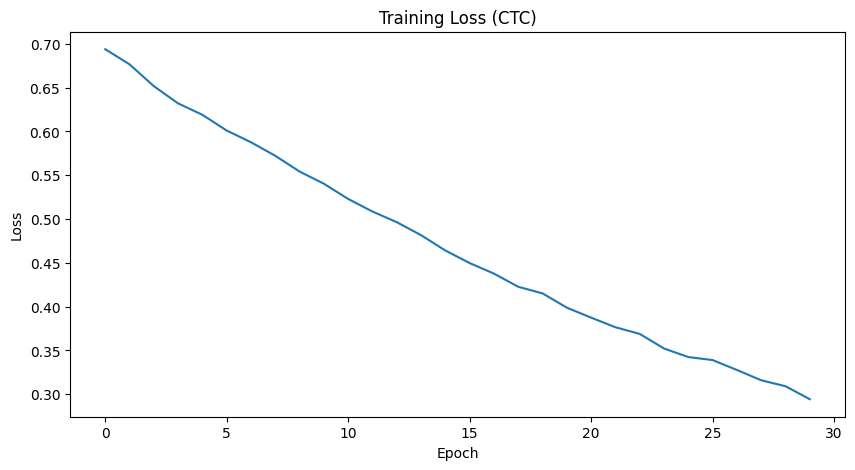

In [25]:
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Training Loss (CTC)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [21]:
model.eval()

vis_log_probs = None
vis_target = None

total_per = 0
num_samples = 0

with torch.no_grad():
    for i, (mfccs, targets, input_lengths, target_lengths) in enumerate(test_loader):
        if mfccs is None: continue

        if i >= 20:
            break

        mfccs = mfccs.to(device)

        log_probs = model(mfccs)

        lp = log_probs[0]
        tgt = targets[0]

        tgt_clean = [t.item() for t in tgt if t != -1]

        likelihood = compute_ctc_forward_prob_scratch(lp, torch.tensor(tgt_clean).to(device))

        greedy_path = ctc_decode_greedy_scratch(lp)
        beam_path = ctc_decode_beam_scratch(lp, beam_width=5)

        per = calculate_wer(tgt_clean, greedy_path)
        total_per += per
        num_samples += 1

        if i < 21:
            print(f"\nExample {i+1}:")
            print(f"Likelihood of Ground Truth: {likelihood:.4f}")
            print(f"Target: {vocab.int_to_text(tgt_clean)}")
            print(f"Greedy: {vocab.int_to_text(greedy_path)}")
            print(f"Beam  : {vocab.int_to_text(beam_path)}")
            print(f"PER   : {per:.2f}")

        if i == 0:
            vis_log_probs = lp.cpu().numpy()

if num_samples > 0:
    print(f"\nAverage PER: {total_per / num_samples:.4f}")


Example 1:
Likelihood of Ground Truth: -38.4303
Target: ['h#', 'hh', 'ih', 'z', 'k', 'ae', 't', 'n', 'w', 'ax', 's', 'th', 'ih', 'n', 'ae', 'n', 'ae', 'g', 'er', 'd', 'n', 'ih', 'z', 'b', 'y', 'dx', 'f', 'b', 'uw', 't', 's', 'epi', 'w', 'w', 'ao', 'r', 'n', 'n', 'epi', 'sh', 'ae', 'b', 'iy', 'h#']
Greedy: ['h#', 'hh', 'ih', 'z', 'k', 'ae', 't', 'n', 'w', 's', 'th', 'ih', 'n', 'ah', 'hh', 'ae', 'g', 'er', 'd', 'ah', 'n', 'z', 'b', 'iy', 'dx', 'f', 'b', 't', 's', 'w', 'w', 'ao', 'r', 'n', 'sh', 'ae', 'b', 'iy', 'h#']
Beam  : ['h#', 'hh', 'ih', 'z', 'k', 'ae', 't', 'n', 'w', 's', 'th', 'ih', 'n', 'ah', 'n', 'hh', 'ae', 'g', 'er', 'd', 'ah', 'n', 'z', 'b', 'iy', 'dx', 'f', 'b', 'uw', 't', 's', 'w', 'w', 'ao', 'r', 'n', 'sh', 'ae', 'b', 'iy', 'h#']
PER   : 0.23

Example 2:
Likelihood of Ground Truth: -34.8607
Target: ['h#', 'dh', 'r', 'iy', 'z', 'ax', 'n', 'z', 'f', 'dh', 'ih', 's', 'd', 'ay', 'v', 's', 'iy', 'm', 'd', 'f', 'uw', 'l', 'sh', 'epi', 'n', 'aw', 'h#']
Greedy: ['h#', 'dh', 'r',

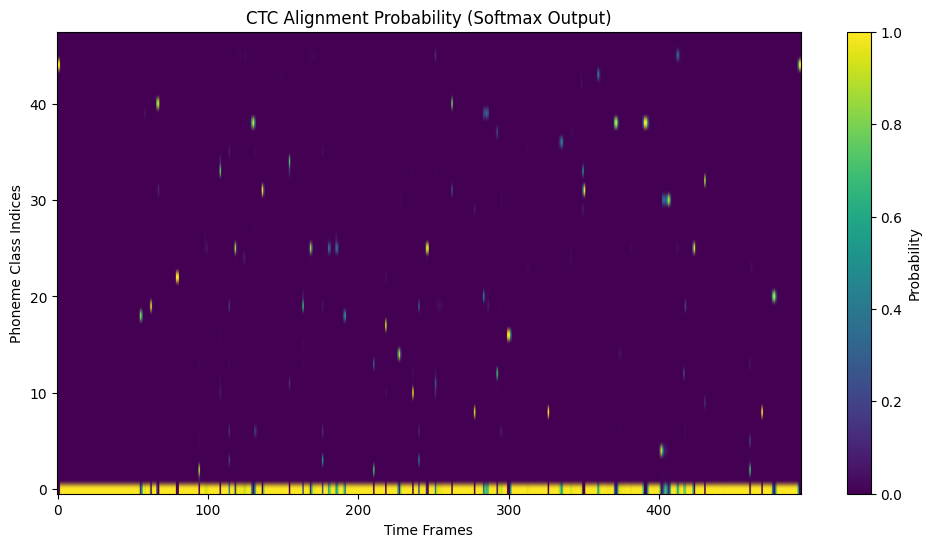

Alignment visualization complete.


In [22]:
if vis_log_probs is not None:
    probs = np.exp(vis_log_probs).T

    plt.figure(figsize=(12, 6))
    plt.imshow(probs, aspect='auto', origin='lower', cmap='viridis')
    plt.colorbar(label="Probability")
    plt.title("CTC Alignment Probability (Softmax Output)")
    plt.xlabel("Time Frames")
    plt.ylabel("Phoneme Class Indices")

    plt.show()
    print("Alignment visualization complete.")